In [2]:
!pip3 install torchmetrics

Defaulting to user installation because normal site-packages is not writeable
  Using cached torchmetrics-1.7.4-py3-none-any.whl (963 kB)
  Using cached torch-2.7.1-cp39-cp39-manylinux_2_28_x86_64.whl (821.1 MB)
  Using cached lightning_utilities-0.14.3-py3-none-any.whl (28 kB)
  Using cached sympy-1.14.0-py3-none-any.whl (6.3 MB)
  Using cached nvidia_cusparselt_cu12-0.6.3-py3-none-manylinux2014_x86_64.whl (156.8 MB)
  Using cached nvidia_cufft_cu12-11.3.0.4-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (200.2 MB)
  Using cached typing_extensions-4.14.1-py3-none-any.whl (43 kB)
  Using cached nvidia_cufile_cu12-1.11.1.6-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (1.1 MB)
  Using cached nvidia_curand_cu12-10.3.7.77-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (56.3 MB)
  Using cached nvidia_nccl_cu12-2.26.2-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (201.3 MB)
  Using cached nvidia_cudnn_cu12-9.5.1.17-py3-none-manylinux_2_28_x86_64.whl (57

In [3]:
import numpy as np
import os
import torch
from torch.utils.data import Dataset, DataLoader
import glob
from model import LightningUNET
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import random

datapath = '/explore/nobackup/people/szhang16/abiChipsNew/'
BATCH_SIZE = 16
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 14
LEARNING_RATE = 0.001
EPOCHS = 100
DATALOADER_WORKERS = 10

ModuleNotFoundError: No module named 'pytorch_lightning'

In [ ]:
# ABI Chip Loader
class AbiChipDataset(Dataset):
    def __init__(self, chip_paths):
        self.chip_paths = chip_paths

    def __len__(self):
        return len(self.chip_paths)

    def __getitem__(self, idx):
        chip = np.load(self.chip_paths[idx], allow_pickle=True)
        image = torch.from_numpy(chip['chip']).permute(2, 0, 1).float()

        return (image, torch.from_numpy(chip['data'].item()['Cloud_mask']).float())

In [37]:
def get_ABI_training_data(chip_dir = datapath, batch_size = BATCH_SIZE):
    chip_paths = glob.glob(chip_dir + '*-6[789][0-9][0-9][0-9]_*.npz')
    dataset = AbiChipDataset(chip_paths)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=DATALOADER_WORKERS)
    return dataloader

def get_ABI_testing_data(chip_dir = datapath, batch_size = BATCH_SIZE):
    chip_paths = glob.glob(chip_dir + '*-71[0-9][0-9][0-9]_*.npz')
    dataset = AbiChipDataset(chip_paths)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=DATALOADER_WORKERS)
    return dataloader

In [38]:
train_set = get_ABI_training_data(datapath, BATCH_SIZE)
test_set = get_ABI_testing_data(datapath, BATCH_SIZE)

In [33]:
len(test_set)

13

In [6]:
pl.seed_everything(42, workers=True)

unet = LightningUNET(in_channels=IMG_CHANNELS, classes=1)
# unet = LightningUNET.load_from_checkpoint("/explore/nobackup/people/szhang16/checkpoints/lightning_logs/version_39074078/checkpoints/epoch=42-step=21457.ckpt")

lr_scheduler = pl.callbacks.LearningRateMonitor(logging_interval='epoch')

trainer = pl.Trainer(
    default_root_dir="/explore/nobackup/people/szhang16/checkpoints",
    max_epochs=EPOCHS,
    deterministic=True,
    accelerator='gpu',
    devices=2,
    callbacks=[lr_scheduler]
)

trainer.fit(model=unet, train_dataloaders=train_set)

[rank: 0] Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type               | Params
---------------------------------------------
0 | model | UNET               | 31.0 M
1 | iou   | BinaryJaccardIndex | 0     
---------------------------------------------
31.0 M    Trainable params
0         Non-trainable params
31.0 M    Total params
124.164   Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 99: 100%|██████████| 499/499 [00:39<00:00, 12.76it/s, loss=0.0281, v_num=3.91e+7, Loss:_step=0.0511, Loss:_epoch=0.0277]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 499/499 [00:40<00:00, 12.43it/s, loss=0.0281, v_num=3.91e+7, Loss:_step=0.0511, Loss:_epoch=0.0277]


In [39]:
trainer.test(model=unet, dataloaders=test_set)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████| 223/223 [00:07<00:00, 29.72it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_iou          │    0.37933245301246643    │
└───────────────────────────┴───────────────────────────┘

[{'test_iou': 0.37933245301246643}]

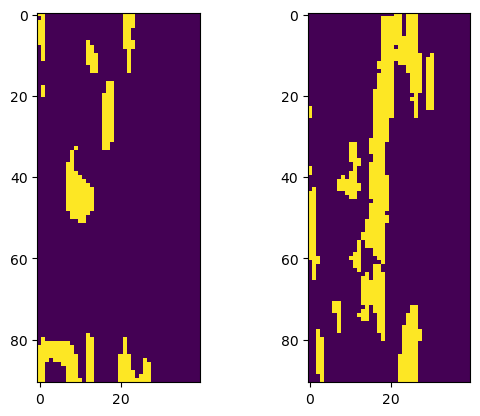

In [30]:
sample_chip = np.load("/explore/nobackup/people/szhang16/abiChipsNew/2019-246-71118_4654-2591-8135.npz", allow_pickle=True)
pred = unet(torch.from_numpy(sample_chip['chip']).permute(2, 0, 1).unsqueeze(0))
pred = torch.sigmoid(pred) > 0.5
fig, axs = plt.subplots(1,2)
img = axs[0].imshow(pred.squeeze().detach().numpy())
axs[1].imshow(sample_chip['data'].item()['Cloud_mask'])
plt.show()

In [20]:
trainer.save_checkpoint("/explore/nobackup/people/szhang16/checkpoints/100epochs.ckpt")